#INSTALLA PYTORCH GEOMETRIC

In [ ]:
!pip install torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
! pip install torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
! pip install torch-cluster==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
! pip install torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
! pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.6.0.html
     |████████████████████████████████| 11.5MB 6.8MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.6.0.html
     |████████████████████████████████| 22.9MB 133kB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.6.0.html
     |████████████████████████████████| 20.3MB 1.2MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.6.0.html
     |████████████████████████████████| 6.1MB 567kB/s 
     |████████████████████████████████| 184kB 4.5MB/s 
     |████████████████████████████████| 235kB 9.5MB/s 
     |████████████████████████████████| 2.2MB 13.9MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.6.1-cp36-none-any.whl size=308552 sha256=36130a336de27ca1d50d6bfa16c691fd3a070a73696f95f6055c4ffdc1736516
  Stored in directory: /root/.cache/pip/wheels/e6/25/ea/3d71d2088dccc63214fa59259dcc598ded4150a5f8b41d84ff
Succ

#INSTALLA IGRAPH

In [ ]:
pip install python-igraph

     |████████████████████████████████| 3.2MB 4.7MB/s 


#INSTALLA CAIRO
serve per plottare i grafi

In [ ]:
!apt-get install libcairo2-dev libjpeg-dev libgif-dev
!pip install pycairo

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libjpeg-dev is already the newest version (8c-2ubuntu8).
libjpeg-dev set to manually installed.
The following additional packages will be installed:
  libcairo-script-interpreter2 libpixman-1-dev libxcb-shm0-dev
Suggested packages:
  libcairo2-doc
The following NEW packages will be installed:
  libcairo-script-interpreter2 libcairo2-dev libgif-dev libpixman-1-dev
  libxcb-shm0-dev
0 upgraded, 5 newly installed, 0 to remove and 21 not upgraded.
Need to get 951 kB of archives.
After this operation, 4,084 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libcairo-script-interpreter2 amd64 1.15.10-2ubuntu0.1 [53.5 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libpixman-1-dev amd64 0.34.0-2 [244 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libxcb-shm0-dev amd64 1.13-2~ubuntu18.04 [6,684 B]
Get:4 http:/

#IMPORT

In [ ]:
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
from torch_geometric.data import DataListLoader
from sklearn.metrics import roc_curve, auc, roc_auc_score
from google.colab import drive
import igraph
from igraph import *
from igraph import Graph
from igraph import GraphBase
import numpy as np
import os
import random
import torch
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch_geometric.nn import GATConv
import time
from os import path as P
from datetime import datetime,timezone
import pytz
import itertools
import gc 
import matplotlib.pyplot as plt
import pandas as pd

#COLLEGO A DRIVE

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


#PATH


In [ ]:
dataset="citeseer"
path="/content/drive/My Drive/Colab Notebooks/TESI/"+dataset+"/"
path2="/content/drive/My Drive/Colab Notebooks/TESI/"+dataset+"/"+dataset+".ncol"
pathcheckpoin="/content/drive/My Drive/Colab Notebooks/TESI/save/checkpoint/"
pathsave="/content/drive/My Drive/Colab Notebooks/TESI/save/"+dataset+"/"
pathgrafoprincipale=pathsave+ 'grafoPrincipaleCiteseer.pt' #contiene il grafo con 2708 nodi e 5k edge
pathsottografo=pathsave+ 'LCC_Citeseer.pt' #contiene il sottografo con i nodi raggiungibili dalla ricerca
pathsottografitrvaltest=pathsave+ 'sottografiCiteseer_tr_val_test.pt' #contiene un dizionario con i sottografi di tr val test
pathdataset=pathsave+ 'dataset_tr_val_test.pt' #contiene il dataset con i batch per poi fare il train
pathsalvataggi=pathsave+'salvataggiCiteSeer.pt'
pathsavedataframe=pathsave+'dataframeCiteSeer.pt'

#CREAZIONE GRAFO PRINCIPALE

In [ ]:
grafoPrincipalePresente=False
if P.exists(pathgrafoprincipale): 
  print("esiste il grafo nei save")
  g=torch.load(pathgrafoprincipale)
  print(g.vcount(),g.ecount())
  grafoPrincipalePresente=True
  
if grafoPrincipalePresente==False:
  print("il grafo non era presente, lo creo")
  g=Graph.Read_Ncol(path2, directed=False)#creo il grafo leggendo dal file con gli edge
  print("Nodi del grafo",g.vcount(),"Edge del grafo",g.ecount())#stampa il grafo
  #g.vs["cites"]=[None for i in range(0,g.vcount())] #aggiungo cites e feature al grafo, per ora sono solo numeri 
  #g.vs["feature"]=[None for i in range(0,g.vcount())]
  print("attributi grafo",g.vs.attribute_names())
  
  print("Letture edge")
  edges_unordered = np.genfromtxt("{}{}.cites".format(path, dataset),dtype=np.int32)#leggo il file che contiene gli edge serve per prendere la lista dei nodi 
  print("Letture feature")
  idx_features_labels = np.genfromtxt("{}{}.content".format(path, dataset),dtype=np.dtype(str))#ha il contenuto quindi le varie feature
 
  features={} #creo un dizionario contenente le feature e le classi e come chiave ha le cites {nodo:[feature],tipo}
  for i in idx_features_labels:
    features[i[0]]=i[1:-1],i[-1]
  print("feature",features)
  
  classi=set() #metto le classi in un set serve dopo per i colori 
  for k in features.keys():
    classi.add(features[k][1])
  print("classi",classi)
  
  color_dict={}
  colori=["red","blue","green","pink","white","gold","orange"]
  c=0
  for i in classi:
    color_dict[i]=colori[c]#faccio un dizionario del tipo class:colore così poi in base alla classe metto il colore
    c=c+1
  c=0
  print("dizionario colori",color_dict)

  nodi=[]
  print("aggiungo feature e classi")
  for v in g.vs:
    nameVertex=v["name"]
    if nameVertex in features.keys():
      v["feature"]=features[v["name"]][0]
      v["classe"]=features[v["name"]][1]
      nodi.append(v.index)

  print("estraggo sottografo") #prendo il sottografo che contiene solo i nodi che servono e si porta dietro gli attributi 
  g=g.subgraph(nodi)# di tutto il grafo di partenza prendo solo quello coi nodi che mi servono così arrivo a 2708 nodi e 5k edge

  g.vs["label"] = g.vs["name"] #aggiungo le label e i colori che servono per il plot del grafo
  g.vs["color"] = [color_dict[classe] for classe in g.vs["classe"]]

  print("Nodi del grafo",g.vcount(),"Edge del grafo",g.ecount())
  print("attributi grafo",g.vs.attribute_names())

  torch.save(g,pathgrafoprincipale) # salvo il grafo per poterlo riusare in futuro 
  print("grafo salvato")
else:
  print("grafo già caricato")

esiste il grafo nei save
3312 4715
grafo già caricato


#PLOT GRAFO PRINCIPALE

In [ ]:
classiColori={}
for v in g.vs:
  classiColori[v["classe"]]=v["color"]

In [ ]:
print("DATASET CITESEER")
print(g.vcount(),g.ecount())
print(classiColori)
layout = g.layout_auto()
plot(g, layout = layout, bbox = (600, 600), margin = 10,vertex_size=10,vertex_label_size=0,edge_width=1)

DATASET CITESEER
3312 4715
{'Agents': 'green', 'HCI': 'blue', 'DB': 'pink', 'IR': 'gold', 'ML': 'white', 'AI': 'red'}


#CREAZIONE SOTTOGRAFO LCC DI RICERCA

In [ ]:
sottografoPresente=False
if P.exists(pathsottografo) : 
  print("esiste il sotto grafo nei save")#contiene il sottografo che ha i nodi incontrati nella ricerca
  sottografo=torch.load(pathsottografo)
  print(sottografo.vcount(),sottografo.ecount())
  sottografoPresente=True

if sottografoPresente==False:
  print("il sotto grafo LCC non era presente, lo creo")
  sottografo=g.clusters().giant()
  print("il sottografo ha ", sottografo.vcount()," vertici e ",sottografo.ecount()," edge")
  torch.save(sottografo,pathsottografo)
  print("sottografo salvato")
else:
  print("sottografo già caricato")

esiste il sotto grafo nei save
2110 3757
sottografo già caricato


#PLOT SOTTO GRAFO PRINCIPALE LCC

GRAFO LCC
2110 3757
{'Agents': 'green', 'HCI': 'blue', 'DB': 'pink', 'IR': 'gold', 'ML': 'white', 'AI': 'red'}


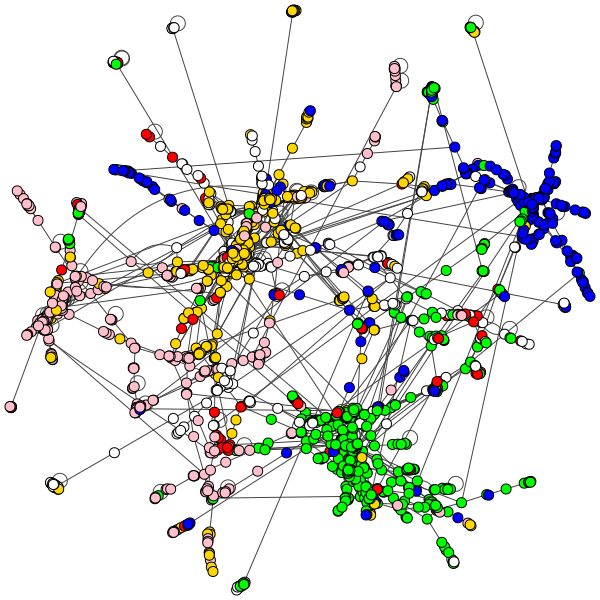

In [ ]:
print("GRAFO LCC")
print(sottografo.vcount(),sottografo.ecount())
print(classiColori)
layout = sottografo.layout_auto()
plot(sottografo, layout = layout, bbox = (600, 600), margin = 10,vertex_size=10,vertex_label_size=0,edge_width=1)

#CREAZIONE DATA

In [ ]:
#gli passo un grafo e da questo si ricava il Data che ha x y e edge index serve per creare il data a partire dal grafo, avrà x,y,edge index
# i dati in uscita saranno x che contiene in pratica tutti i nodi e le loro feature, se il grafo ha 100 nodi con 50 feature x è del tipo 100x50
#y contiene se esiste o meno un link sarà il quadrato dei nodi che considero importanti o interest appunto, se per esempio ho 50 nodi la y avraà dim 250.000x1
#edge index dato che consideriamo i nodi sia i->j che j->i sarà di dim 2xnumeroEdge
#mask invece sarà fatta da true o false in base a quanti nodi consideriamo importati quindi se ho 100 nodi e solo 20 importanti avrè 20 true sparsi per l'array che è d dim 100x1, serve per prendere solo 
#quelli importanti per hadamard
def create_data(g,tipografo):
  #creo la x che non è altro che una matrice che contine come righe le feature quindi saraà del tipo numNodiXnumFeature
  x=[g.vs[i]["feature"] for i in range(0,g.vcount())]
  x=np.column_stack(tuple([[float(y) for y in x] for x in x]))
  x = torch.from_numpy(x).to(torch.float)
  x=x.t()
  #credo edge_index 
  edge_index = np.empty((2, 2 * g.ecount()), dtype=np.int32)
  i = 0
  for e in g.get_edgelist():
    edge_index[:, i] = (g.vs[e[0]].index, g.vs[e[1]].index)
    edge_index[:, i + 1] = (g.vs[e[1]].index, g.vs[e[0]].index)
    i += 2

  if len(edge_index[0])==0:
    edge_index = np.zeros((2, 2), dtype=np.int32)
  
  edge_index = torch.from_numpy(edge_index).to(torch.long)

  #credo la y e mentre la mask, la y dice se esiste un link tra un nodo e un altro
  y=[]
  mask=[]
  random.seed(0)
  if tipografo=="train":
    #prima mi prendo le coppie con gli edge sicuri, quelli che appunto mi dà il grafo
    edgeSicuri=g.get_edgelist()
    edgeSicuri=random.sample(edgeSicuri,len(edgeSicuri)) 

    #mi credo delle liste che contengono i nodi per poi creare delle tuple che molto probabilmente saranno degli 0 
    lista1=[i for i in range(0,g.vcount())]
    lista2=[i for i in range(0,g.vcount())]
    lista1=random.sample(lista1,len(lista1))
    lista2=random.sample(lista2,len(lista2))
    z = list(zip(lista1,lista2))
    while len(z)<len(edgeSicuri): #faccio in modo che abbia almeno la dimensione di edgesicuri
      lista1=random.sample(lista1,len(lista1))
      lista2=random.sample(lista2,len(lista2))
      z=z+list(zip(lista1,lista2))
    z=z[:len(edgeSicuri)] # se magari è superiore la riduco
    z=random.sample(z,len(z))
    edgeSicuri=edgeSicuri+z# concateno le due e poi faccio uno shuffle in modo da non avere tutto 0 o 1 di fila
    edgeSicuri=random.sample(edgeSicuri,len(edgeSicuri))
    target=[] #nel target metto gli 0 o 1
    indice0=[] # dato che considero le coppie di nodi avrò due nodi che li metto negli indici li userò dopo per semplificare il calcolo di hadamard
    indice1=[]
    # indice0 e indice1 in realtà sono source e target di un determinato edge
    for e in edgeSicuri:
      v=g.vs[e[0]]# prendo i vertici v e u per vedere se esiste l'edge
      u=g.vs[e[1]]
      indice0.append(e[0])
      indice1.append(e[1])
      id=g.get_eid(v,u,directed=False,error=False)
      if id!=-1: target.append(1)
      else : target.append(0)
    y=target
  else:
    edgelistSicuri=[]# prendo quella che è la edgelist ma considerando solo i nodi di interesse, non c'è un metodo per prenderli passando i vertici
    listainterest=[]
    for v in g.vs():
      if v["interest"]==True:
        listainterest.append(v.index)
        for u in g.vs():
          if u["interest"]==True:
            id=g.get_eid(v,u,directed=False,error=False)
            if id!=-1: 
              c=(v.index,u.index)
              edgelistSicuri.append(c)

    edgelistSicuri=random.sample(edgelistSicuri,len(edgelistSicuri))#li mischio 
    lista1=random.sample(listainterest,len(listainterest))#faccio come sopra che credo delle liste con dei nodi per poi creare coppie false che non hanno edge
    lista2=random.sample(listainterest,len(listainterest))
    z=list(zip(lista1,lista2))
    while len(z)<len(edgelistSicuri): #faccio in modo che abbia almeno la dimensione di edgesicuri
      lista1=random.sample(lista1,len(lista1))
      lista2=random.sample(lista2,len(lista2))
      z=z+list(zip(lista1,lista2))
    z=z[:len(edgelistSicuri)]
    edgelistSicuri=edgelistSicuri+z
    edgelistSicuri=random.sample(edgelistSicuri,len(edgelistSicuri)) #mischio di nuovo 
    target=[] #nel target metto gli 0 o 1
    indice0=[] # dato che considero le coppie di nodi avrò due nodi che li metto negli indici li userò dopo per semplificare il calcolo di hadamard
    indice1=[]
    # indice0 e indice1 in realtà sono source e target di un determinato edge
    for e in edgelistSicuri:
      v=grafo.vs[e[0]]# prendo i vertici v e u per vedere se esiste l'edge
      u=grafo.vs[e[1]]
      indice0.append(e[0])
      indice1.append(e[1])
      id=grafo.get_eid(v,u,directed=False,error=False)
      if id!=-1: target.append(1)
      else : target.append(0)
    y=target

  if len(y)==0: y.append(0)
  y=torch.FloatTensor(y)

  data = Data(x=x.contiguous(), edge_index=edge_index.contiguous(), y=y.contiguous(), mask=mask, indice0=indice0, indice1=indice1)
  return data

#CREAZIONE SOTTOGRAFI E DATASE


In [ ]:
sottografitrvaltestPresente=False
if P.exists(pathsottografitrvaltest): 
  print("esisteno i sotto grafi nei save")#contiene il sottografo che ha i nodi incontrati nella ricerca
  sottografi=torch.load(pathsottografitrvaltest)
  subGrapTr=sottografi["train"]
  subGrapVal=sottografi["val"]
  subGrapTest=sottografi["test"]
  for i in sottografi:
    print(i,"vertici",sottografi[i].vcount(),"edge",sottografi[i].ecount())
  sottografitrvaltestPresente=True
  if P.exists(pathdataset): 
    print("esiste il dataset dei sotto grafi nei save")
    datasetsubgrafi=torch.load(pathdataset)
    datasetSottografiPresente=True


if sottografitrvaltestPresente==False:
  random.seed(0)
  print("sotto grafi di ricerca non presenti, li creo")
  nodiRaggiungibili=sottografo.vcount()
  trnodi=round(nodiRaggiungibili*0.7)
  valnodi=round(nodiRaggiungibili*0.2)
  testnodi=round(nodiRaggiungibili*0.1)
  listaNodiTR=set()
  listaNodiVal=set()
  listaNodiTest=set()
  listaNodiTotali=[i for i in range(0,nodiRaggiungibili)]


  #CREO 2 SET, li riempio con valori random
  # uno per val con il 20% dei nodi del LCC e l'altro test col 20%
  # i due set non hanno valori in comune
  while len(listaNodiVal)<valnodi:
    p=random.randint(0,nodiRaggiungibili)
    listaNodiVal.add(p)
  while len(listaNodiTest)<testnodi:
    n=random.randint(0,nodiRaggiungibili)
    if n  not in listaNodiVal: listaNodiTest.add(n)

  #creo delle liste contenenti i nodi per i sottografi
  l3=list(listaNodiTest)+list(listaNodiVal) #questo contiene sia i nodi di val che test chepoi non conterrà il train 
  # la lista del tr contiene tutti i nodi meno quelli di test e val
  listaNodiTrsub=[x for x in listaNodiTotali if x not in l3] # con questo prendo il grafo di tr non sono presenti i nodi di val e test 
  #la lista dei nodi di val contiene tutti i nodi di lcc meno quelli di test
  listaNodiValsub=[x for x in listaNodiTotali if x not in list(listaNodiTest)] #dai 2400 nodi tolgo quelli di test stessa cosa dopo 
  #con questo prendo i nodi di test senza considerare quelli di val 
  listaNodiTestsub=[x for x in listaNodiTotali if x not in list(listaNodiVal)]

  #faccio delle copie del LCC
  test=sottografo.copy() #copio lcc sia per test che per val che per tr
  val=sottografo.copy()
  train=sottografo.copy()

  #vado ad aggiungere un attributo in questi grafi di test e val per capire quali sono i nodi di interesse cioè quelli che avevamo selezionato random per poi usarli per fare i confronti
  #sono per poi dopo rimuovere questi edge
  #lista nodi val contiene dei nodi random che sono di val solo e unicamente di val, poi nel grafico di val ci saranno questi nodi più quelli di train e no di test
  #per test è il viceversa
  for v in val.vs:
    if v.index in listaNodiVal:
      val.vs[v.index]["interest"]=True
    else: val.vs[v.index]["interest"]=False
  #aggiungo attributo a tot nodi random di test
  for v in test.vs:
    if v.index in listaNodiTest:
      test.vs[v.index]["interest"]=True
    else: test.vs[v.index]["interest"]=False


  #da questi 3 grafi che sono la copia di LCC metto questo attributo ai nodi di interesse ma poi prendo solo una lista che mi interessa
  #listaNodiTrsub,listaNodiValsub,listaNodiTestsub contengono i nodi che voglio estrarre dal sottografo LCC, sono presi partendo dai circa 2400 che sono quelli di llc e scelti randm
  #i nodi di val non coincidono con quelli di test 
  #SOTTOGRAFO SAREBBE LCC
  # per il sottografo di tr basta considerare tutti i nodi meno quelli di test e val prendo il cluster più grande
  subGrapTr=train.subgraph(listaNodiTrsub,implementation="create_from_scratch").clusters().giant() 
  #prendo i vari sottografi di test e val da LCC iniziale
  subGrapVal=val.subgraph(listaNodiValsub,implementation="create_from_scratch").clusters().giant()# prendo il cluster più grande che sarebbe lcc 
  subGrapTest=test.subgraph(listaNodiTestsub,implementation="create_from_scratch").clusters().giant()

  sottografi={"train":subGrapTr,"val":subGrapVal,"test":subGrapTest} # li metto in un dizionario per praticità 
  #ora ho 3 grafi che sono i 3 sottografi tutti e 3 lcc
  #in val e test ho degli attributi che servono a dire se alcuni nodi sono più importanti perchè sono quelli scelti random e quindi da considerare, ora c'è anche in train
  #posso creare i vari Data perchè ancora non ho scollegato i link dei nodi importanti 
  print("dimensioni sub grafo tr",subGrapTr.vcount(),subGrapTr.ecount())
  print("dimensioni sub grafo val",subGrapVal.vcount(),subGrapVal.ecount())
  print("dimensioni sub grafo test",subGrapTest.vcount(),subGrapTest.ecount())


  print("Creazione del dataset")
  datasetsubgrafi={}
  for graph in sottografi:  # sottografi è un dizionario quindi da questo prendo il grafo di train val e test
    grafo=sottografi[graph]    
    data=create_data(grafo,graph)
    datasetsubgrafi[graph]=data 
  torch.save(datasetsubgrafi,pathdataset)
  print("dataset salvato")

  
  #da lcc rimuovo i collegamenti dei nodi nel set di test stessa cosa dopo per il val
  #rimuovo gli edge dal set di test e poi dopo anche per quello di val
  #in pratica parto da LCC da questo tolgo i nodi di val quando considero il test e tolgo anche gli edge del set del test
  # viceversa per il val quindi considero LCC senza i nodi di test e senza gli edge del val 
  # l'operazione di rimuovere gli edge si fa solo sui grafi di val e test
  
  #RIMOZIONE EDGE TEST----------------------------------------------------------------------------------------------------------------------------------------------------------
  for v in subGrapTest.vs: #scorro i nodi di test
    if v["interest"]==True: #controllo se sono presenti nella lista test
      for u in subGrapTest.vs: #vedo con che nodo è connesso  controllare solo per i nodi di test fare lo stesso per la val
        if u["interest"]==True:
          id=subGrapTest.get_eid(v,u,directed=False,error=False) #prendo id di edge e lo rimuovo in pratica controllo se per un nodo nel set di test esiste un link
          if id != -1: subGrapTest.delete_edges(id)#; print("elinino test",id) #con un altro nodo nel set di test 
  #RIMOZIONE EDGE VAL-----------------------------------------------------------------------------------------------------------------------------------------------------------
  for v in subGrapVal.vs:      #scorro i nodi di val 
    if v["interest"]==True:  #se incontro un nodo che è presente in val
      for u in subGrapVal.vs: #controllo a quale nodo è collegato 
        if u["interest"]==True:
          id=subGrapVal.get_eid(v,u,directed=False,error=False) # prendo l'id dell'edge e lo elimino
          if id != -1: subGrapVal.delete_edges(id)#; print("elimino val",id) # come sopra
  #ora che ho rimosso i link dei nodi che avevo preso random avroò nei grafi alcuni nodi isolati non è un problema,mentre per il train non si verifica perchè non li ho scollegati, ma ne ho comunque alcuni importanti

  print("dimensioni sub grafo tr",subGrapTr.vcount(),subGrapTr.ecount())
  print("dimensioni sub grafo val",subGrapVal.vcount(),subGrapVal.ecount())
  print("dimensioni sub grafo test",subGrapTest.vcount(),subGrapTest.ecount())

  print("creati i sotto grafi")# li rimetto nel dizionario e li salvo 
  #sottografi={"train":subGrapTr,"val":subGrapVal,"test":subGrapTest}# li metto in un dizionario che poi salvo 

  torch.save(sottografi,pathsottografitrvaltest)
  print("sotto grafi salvati")
else:
  print("sottografi già caricati")

esisteno i sotto grafi nei save
train vertici 956 edge 1470
val vertici 1747 edge 2783
test vertici 1227 edge 1975
esiste il dataset dei sotto grafi nei save
sottografi già caricati


In [ ]:
datasetsubgrafi,sottografi

({'test': Data(edge_index=[2, 4018], indice0=[130], indice1=[130], mask=[0], x=[1227, 3703], y=[130]),
  'train': Data(edge_index=[2, 2940], indice0=[2940], indice1=[2940], mask=[0], x=[956, 3703], y=[2940]),
  'val': Data(edge_index=[2, 5850], indice0=[548], indice1=[548], mask=[0], x=[1747, 3703], y=[548])},
 {'test': <igraph.Graph at 0x7fdd77082228>,
  'train': <igraph.Graph at 0x7fdd7a12ae58>,
  'val': <igraph.Graph at 0x7fdd77082048>})

In [ ]:
for grafo in ["train","val","test"]:
  print("INFO GRAFO:",sottografi[grafo].vcount(),sottografi[grafo].ecount())
  lunghezzay=len(datasetsubgrafi[grafo].y)
  uno_iny=len(torch.nonzero(datasetsubgrafi[grafo].y))
  zero_iny=lunghezzay-uno_iny
  print("lunghezza Y:",lunghezzay)
  print("quanti 1:",uno_iny)
  print("quanti 0:",zero_iny)
  print("-"*150)

INFO GRAFO: 956 1470
lunghezza Y: 2940
quanti 1: 1475
quanti 0: 1465
------------------------------------------------------------------------------------------------------------------------------------------------------
INFO GRAFO: 1747 2783
lunghezza Y: 548
quanti 1: 274
quanti 0: 274
------------------------------------------------------------------------------------------------------------------------------------------------------
INFO GRAFO: 1227 1975
lunghezza Y: 130
quanti 1: 65
quanti 0: 65
------------------------------------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  after removing the cwd from sys.path.


#PLOT DEI SOTTO GRAFI

SOTTOGRAFO TRAIN
956 1470
{'Agents': 'green', 'HCI': 'blue', 'DB': 'pink', 'IR': 'gold', 'ML': 'white', 'AI': 'red'}


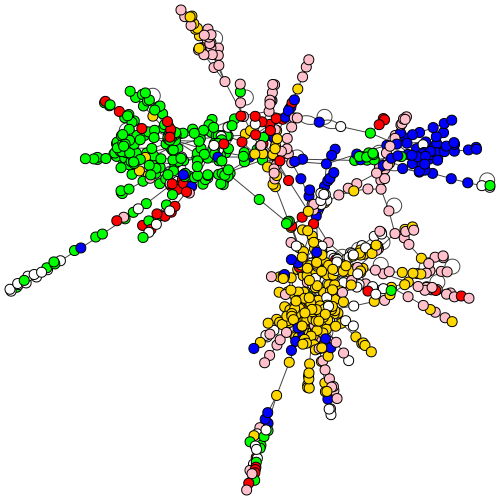

In [ ]:
print("SOTTOGRAFO TRAIN")
print(subGrapTr.vcount(),subGrapTr.ecount())
print(classiColori)
layout = subGrapTr.layout_auto()
plot(subGrapTr, layout = layout, bbox = (500, 500), margin = 10,vertex_size=10,edge_width=1,vertex_label_size=0) #togliare i nodi isolati cercare funzione lcc 

SOTTOGRAFO VAL
1747 2783
{'Agents': 'green', 'HCI': 'blue', 'DB': 'pink', 'IR': 'gold', 'ML': 'white', 'AI': 'red'}


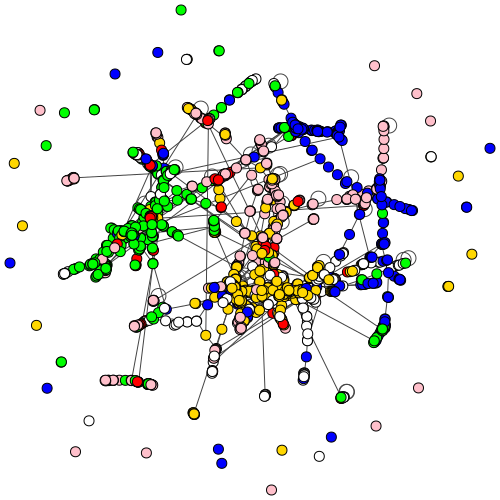

In [ ]:
print("SOTTOGRAFO VAL")
print(subGrapVal.vcount(),subGrapVal.ecount())
print(classiColori)
layout = subGrapVal.layout_auto()
plot(subGrapVal, layout = layout, bbox = (500, 500), margin = 10,vertex_size=10,vertex_label_size=0,edge_width=1)#prendere sempre lcc

SOTTOGRAFO TEST
1227 1975
{'Agents': 'green', 'HCI': 'blue', 'DB': 'pink', 'IR': 'gold', 'ML': 'white', 'AI': 'red'}


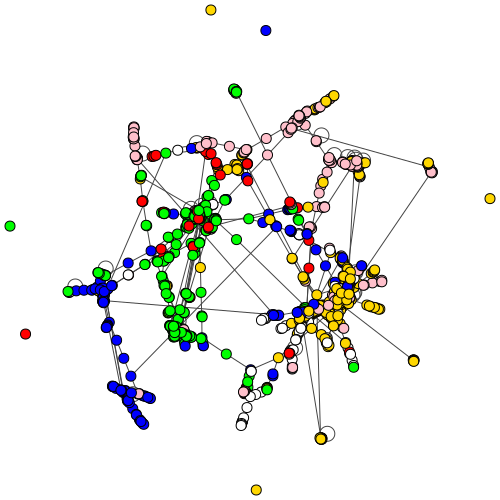

In [ ]:
print("SOTTOGRAFO TEST")
print(subGrapTest.vcount(),subGrapTest.ecount())
print(classiColori)
layout = subGrapTest.layout_auto()
plot(subGrapTest, layout = layout, bbox = (500, 500), margin = 10,vertex_size=10,vertex_label_size=0,edge_width=1)

In [ ]:
gc.collect()
torch.cuda.empty_cache()

#MODELLO

In [ ]:
from torch.nn import functional as F
from torch.autograd import Variable
class GAT(nn.Module):

  #INIT--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  def __init__(self, h_sizes, out_size, inOutDim,head,layerLin,linear):
    super(GAT, self).__init__()
    
    torch.manual_seed(0)
    # Hidden layers GAT-------------------------------------------------------
    self.hidden = nn.ModuleList()
    if h_sizes>1: #controllo se ci sono più livelli e in caso li metto in una lista
      for k in range(h_sizes-1):
          self.hidden.append(GATConv(inOutDim[k]*head[k-1] if k!=0 else inOutDim[k] ,inOutDim[k+1],heads=head[k]))
      # ULTIMO LAYER GAT------------------------------------------------------
      self.hidden.append(GATConv(inOutDim[-1]*head[-2], linear[0],heads=1,concat=False))
    else : #altrimenti metto solo 1 livello 
      self.hidden.append(GATConv(inOutDim[0]*head[0], linear[0],heads=1,concat=False))
  
    # LIVELLO LINEARE---------------------------------------------------------
    self.fc = nn.ModuleList() #metto i livelli o livello lineare
    for k in range(0,layerLin):
        self.fc.append(nn.Linear(linear[k], 1 if k+2>len(linear) else linear[k+1]))

  
  #HADAMARD----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  def hadamardProd1(self,hadamard,device,indice0,indice1): #serve per il prodotto di hadamard
    #creare direttamente il tensore e mettere le righe 
    #hadaprod=Variable(torch.zeros(hadamard.size()[0]**2,hadamard.size()[1])).to(device)
    hadaprod=Variable(torch.zeros(len(indice0),hadamard.size()[1])).to(device)
    
    '''for i in range(hadamard.size()[0]):
      for j in range(hadamard.size()[0]):
        hadaprod[i*hadamard.size()[0]+j]=torch.mul(hadamard[i],hadamard[j])'''
    #indice0 e 1 contengono i nodi che hanno generato 0 o 1 come link
    # per esempio il primo elemento di indice0 è 500 e il primo di indice1 è 200 allora considero questi 2 nodi e li devo prendere dalla x che mi arriva
    #che ha la stessa dimensione del numero di nodi per le feature
    for i,j in enumerate(indice0):#j è quello che c'è in indice0 mentre i è un contatore quindi lo uso per prendere quello che c'è in indice1
      hadaprod[i]=torch.mul(hadamard[j],hadamard[indice1[i]])     
    
    gc.collect()
    torch.cuda.empty_cache()
    return hadaprod

  #FORWARD-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  def forward(self, data,device): 
    x, edge_index,mask,indice0,indice1 = data.x, data.edge_index, data.mask,data.indice0,data.indice1

    #FACCIO GLI STRATI DI GAT HIDDEN------------------------------------------
    for layer in self.hidden: #faccio passare per i livelli gat e apllico la elu come FA
      x = layer(x,edge_index)
      x= F.elu(x)

    #CALCOLO IL PRODOTTO DI HADAMARD -----------------------------------------
    # prendere solo i nodi della mask ovviamente per il train li prendo tutti 
    #x=x[mask]

    x=self.hadamardProd1(x,device,indice0,indice1)           

    #CALCOLO OUT DEI LIVELLI LINEARI -----------------------------------------
    for layer in self.fc: #la faccio passare per i livelli lineari con FA relu 
      x=layer(x)
      #x=F.relu(x)

    #CALCOLO LA SIGMOID ------------------------------------------------------
    x=torch.sigmoid(x)
  
    x = x.view(x.size(0))
 
    return x

#TRAIN

In [ ]:
def accuracy(output, labels):
    assert output.size() == labels.size()
    output = output > 0.5
    preds = output.type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / float(len(labels))

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs,best_val_accuracy,best_val_auc, history_loss, history_accuracy,history_accuracy_AUC,stoppato):
  
  #inizializzazione parametri
  epoch_loss={"train": [], "val": [], "test": []}
  epoch_acc_normale={"train": [], "val": [], "test": []}
  epoch_acc_AUC={"train": [], "val": [], "test": []}
  
  try:
    #EPOCHE------------------------------------------------------------------------------------------------------------------------------------------------
    for epoch in range(num_epochs):
      since = time.time()
      #print("-" * 150)
      #print("Epoch {}/{}".format(epoch+1, num_epochs))
      tz = pytz.timezone('Etc/GMT-2')
      now = datetime.now(tz=tz)
      current_time = now.strftime("%H:%M:%S")
      #print("Current Time =", current_time)
      
      # processo per ogni fase, quindi train e val
      #fasi del modello --------------------------------------------------------------------------------------------------------------------------------
      for phase in ["train", "val", "test"]:
      #for phase in [ "val"]:
        if phase == "train":
          model.train()  # Set model to training mode
          torch.set_grad_enabled(True)
        else:
          model.eval()  # Set model to evaluate mode
          torch.set_grad_enabled(False)
        
        # prendo il Data per ogni fase. LO PORTO AL DEV E PRENDO LE Y PER LA LOSS E ACC
        data=dataloaders[phase]
        data=data.to(device)
        labels=data.y

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(data,device)     
        
        #LOSS
        loss = criterion(outputs,labels) # FACCIO LA SOGLIA DIRETTAMNETE QUA DENTRO

        epoch_loss[phase] = loss.item()
        # backward + optimize solo per la fase di train
        if phase == "train":
          loss.backward()
          optimizer.step()

        #ACCURATEZZA
        # per accuratezza uso auc della curva roc e anche accuratezza normale
        epoch_acc_normale[phase]=accuracy(outputs,labels).item()#questa è l'accuratezza normale
        
        out=outputs.detach().cpu().numpy()# questo server per poi fare la auc
        accAuc=roc_auc_score(labels.cpu(),out)#dato che ho tolto la sig dal modello la metto dentro la acc
        epoch_acc_AUC[phase] = accAuc

        #print("Fase :",phase,"\t | Loss :","{:.3f}".format(epoch_loss[phase])," | AUC :" ,"{:.3f}".format(epoch_acc_AUC[phase])," | Acc :" ,"{:.3f}".format(epoch_acc_normale[phase]))
      
      for phase in ["train", "val", "test"]:
        history_loss[phase].append(epoch_loss[phase])
        history_accuracy[phase].append(epoch_acc_normale[phase])  
        history_accuracy_AUC[phase].append(epoch_acc_AUC[phase])  
      # Ccontrollo se ho ottenuto la migliore accuratessa 
      if epoch_acc_normale["val"]>best_val_accuracy:
        # aggiorno se è migliore 
        best_val_accuracy=epoch_acc_normale["val"]
      if epoch_acc_AUC["val"]>best_val_auc:
        # aggiorno se è migliore 
        best_val_auc=epoch_acc_AUC["val"]
      
      time_elapsed = time.time() - since
      #print("Epoch complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
  
  except KeyboardInterrupt:
    print("Interrupted")   
    stoppato=True
  print("#"*150)
  print("Cinesi = 0.85 Best val Acc: {:.2f}".format(best_val_accuracy))
  print("Cinesi = 0.91 Best val AUC: {:.2f}".format(best_val_auc))
  return model, best_val_accuracy,best_val_auc, optimizer, history_loss, history_accuracy,history_accuracy_AUC,stoppato

#GENERAZIONE MODELLI

In [ ]:
featureInputSize=datasetsubgrafi["train"].x.size()[1] # questo è standard per tutti
outputGat=[20,40]
head=[
      [1],[1,1],[1,1,1],[1,1,1,1],
      [4,1],[1,4,1],
      ]
out1=outputGat[0]
out2=outputGat[1]
linear=[
        [out1],[out1,10],
        [out2],[out2,20,10],
]
c = list(itertools.product(head, linear))#creo tutte le combinazioni tra head e linear

In [ ]:
modelli=[]
for factor in [1.5,2,5,10]:# sono diversi fattori per dividere gli input output
  for j,i in enumerate(c):
    inOutDim=[]
    head=i[0]
    linear=i[1]
    outputGat=i[1][0]
    layerGat=len(head) 
    layerLin=len(linear)  

    inOutDim.append(featureInputSize) 
    for i in range(1,layerGat):
      inOutDim.append(round(inOutDim[i-1]/factor))

    m=GAT(layerGat, outputGat ,inOutDim,head,layerLin,linear)
    modelli.append(m)#creo i modelli e li metto nella lista
    m=None

In [ ]:
if P.exists(pathsalvataggi): #controllo se ci sono i salvataggi
  print("alcune prove sono già state fatte")
  salvataggi=torch.load(pathsalvataggi)
else:
  print("ancora non ci sono prove")
  salvataggi={}

ancora non ci sono prove


#FASE TRAIN

In [ ]:
lr=5e-4
weight_decay=5e-4
betas=(0.5,0.999)
num_epochs=100
for i,m in enumerate(modelli):#prendo un modello dalla lista e faccio il train al solito passando a device e con optim
  print("MODELLO",i)
  if i<len(salvataggi):pass 
  else :
    stoppato=False
    optimizer = optim.Adam(m.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #model=None
    model = m.to(device)
    gc.collect()
    torch.cuda.empty_cache()
    criterion=nn.BCELoss()    

    best_val_accuracy = 0.0
    best_val_auc=0.0
    history_loss = {"train": [], "val": [], "test": []}
    history_accuracy = {"train": [],  "val": [], "test": []}
    history_accuracy_AUC = {"train": [],  "val": [], "test": []}

    model, best_val_accuracy,best_val_auc,optimizer,history_loss,history_accuracy,history_accuracy_AUC,stoppato = train_model(
    model,datasetsubgrafi,
    criterion,    optimizer,
    device,    num_epochs,
    best_val_accuracy,    best_val_auc,
    history_loss,    history_accuracy,
    history_accuracy_AUC,stoppato)

    if stoppato==True:break
    checkpoint = { 
              'history_loss':history_loss,
              'history_accuracy':history_accuracy,
              'history_accuracy_AUC':history_accuracy_AUC,
              'best_val_accuracy':best_val_accuracy,
              'best_val_auc':best_val_auc,
    }
    salvataggi["modello"+str(i)]=checkpoint
    torch.save(salvataggi,pathsalvataggi)
    gc.collect()
    torch.cuda.empty_cache()

MODELLO 0
######################################################################################################################################################
Cinesi = 0.85 Best val Acc: 0.66
Cinesi = 0.91 Best val AUC: 0.75
MODELLO 1
######################################################################################################################################################
Cinesi = 0.85 Best val Acc: 0.63
Cinesi = 0.91 Best val AUC: 0.79
MODELLO 2
######################################################################################################################################################
Cinesi = 0.85 Best val Acc: 0.69
Cinesi = 0.91 Best val AUC: 0.83
MODELLO 3
######################################################################################################################################################
Cinesi = 0.85 Best val Acc: 0.71
Cinesi = 0.91 Best val AUC: 0.87
MODELLO 4
##################################################################################

#ANALISI DATI

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from google.colab import drive

In [3]:
drive.mount('/content/drive')
dataset="citeseer"
pathsave="/content/drive/My Drive/Colab Notebooks/TESI/save/"+dataset+"/"
pathsalvataggi=pathsave+'salvataggiCiteSeer.pt'
pathsavedataframe=pathsave+'dataframeCiteSeer.pt'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
dati=torch.load(pathsalvataggi)# carico i salvataggi fatti coi vari train
#ricreo i modelli come sopra che mi serviranno i vari parametri per la dataframe
featureInputSize=3703 # questo è standard per tutti
outputGat=[20,40]
head=[
      [1],[1,1],[1,1,1],[1,1,1,1],
      [4,1],[1,4,1],
      ]
out1=outputGat[0]
out2=outputGat[1]
linear=[
        [out1],[out1,10],
        [out2],[out2,20,10],
]
c = list(itertools.product(head, linear))#creo tutte le combinazioni tra head e linear
#creo delle liste dove mettere i vari dati/parametri
bestAUC=[]
bestACC=[]
livelliGat=[]
livelliLinear=[]
numHead=[]
output=[]
nomeModelli=[]
fattoreRiduzione=[]
lossMin=[]
feature=[]
num=0
for factor in [1.5,2,5,10]:
  for e in c:
    livelliGat.append(len(e[0]))
    numHead.append(max(e[0]))
    livelliLinear.append(len(e[1]))
    output.append(e[1][0])
    bestAUC.append(dati["modello"+str(num)]["best_val_auc"])
    bestACC.append(dati["modello"+str(num)]["best_val_accuracy"])
    lossMin.append(min(dati["modello"+str(num)]["history_loss"]["val"]))
    nomeModelli.append("modello"+str(num))
    fattoreRiduzione.append(factor)
    feature.append(featureInputSize)
    num+=1
#creo la dataframe che poi porto a panda e la salvo per riprenderla dopo
dataframe={
    "Modelli":nomeModelli,
    "BestAUC":bestAUC,
    "BestACC":bestACC,
    "LivelliLineari":livelliLinear,
    "LivelliGat":livelliGat,
    "Head":numHead,
    "Output":output,
    "FattoreRiduzione":fattoreRiduzione,
    "lossMin":lossMin,
    "NumFeatures":feature
}
df = pd.DataFrame (dataframe, columns = dataframe.keys())
torch.save(df,pathsavedataframe)

In [7]:
df

Modelli   BestAUC   BestACC  ...  FattoreRiduzione   lossMin  NumFeatures
0    modello0  0.746071  0.660584  ...               1.5  0.603915         3703
1    modello1  0.790293  0.627737  ...               1.5  0.579813         3703
2    modello2  0.827588  0.691606  ...               1.5  0.541778         3703
3    modello3  0.874674  0.711679  ...               1.5  0.523377         3703
4    modello4  0.867921  0.755474  ...               1.5  0.501483         3703
..        ...       ...       ...  ...               ...       ...          ...
91  modello91  0.879216  0.775547  ...              10.0  0.548563         3703
92  modello92  0.872409  0.771898  ...              10.0  0.532786         3703
93  modello93  0.810765  0.709854  ...              10.0  0.590200         3703
94  modello94  0.886582  0.777372  ...              10.0  0.475144         3703
95  modello95  0.828001  0.713504  ...              10.0  0.557269         3703

[96 rows x 10 columns]

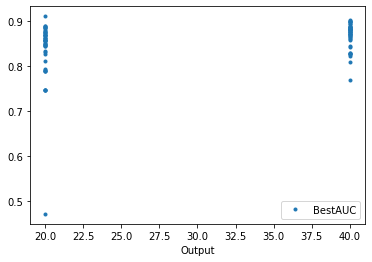

In [ ]:
df.plot("Output","BestAUC",style='.')

['modello10', 'modello58', 'modello76']
GAT(
  (hidden): ModuleList(
    (0): GATConv(3703, 370, heads=1)
    (1): GATConv(370, 20, heads=1)
  )
  (fc): ModuleList(
    (0): Linear(in_features=20, out_features=1, bias=True)
  )
)
0.8138686131386861
0.9001944696041344


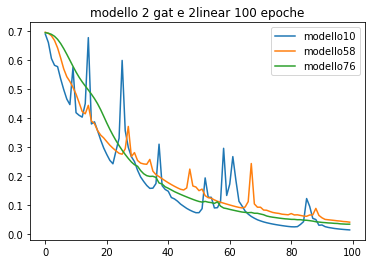

In [ ]:
l=[]
varimod=[]
numModello=""
for v in salvataggi:
  if salvataggi[v]["best_val_auc"]>0.9:
   l.append(salvataggi[v]["history_loss"]["train"])
   varimod.append(v)
   numModello=int(v.replace("modello",""))

print(varimod)
print(modelli[numModello])
print(salvataggi[varimod[0]]["best_val_accuracy"])
print(salvataggi[varimod[0]]["best_val_auc"])
#LOSS
plt.title("modello 2 gat e 2linear "+str((len(history_loss["val"])))+" epoche")
for i in range(len(l)):
  plt.plot(l[i],label=varimod[i])
plt.legend()
#plt.savefig(imagePath+'LossTrainClassificatoreCompleto.png')
plt.show()


No handles with labels found to put in legend.


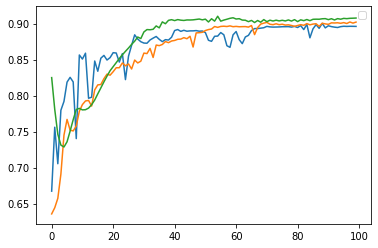

In [ ]:
l=[]
for v in salvataggi:
  if salvataggi[v]["best_val_auc"]>0.9:
    l.append(salvataggi[v]["history_accuracy_AUC"]["val"])
#LOSS
#plt.title("modello 2 gat e 2linear "+str((len(history_loss["val"])))+" epoche")
for i in range(len(l)):
  plt.plot(l[i])
plt.legend()
#plt.savefig(imagePath+'LossTrainClassificatoreCompleto.png')
plt.show()

No handles with labels found to put in legend.


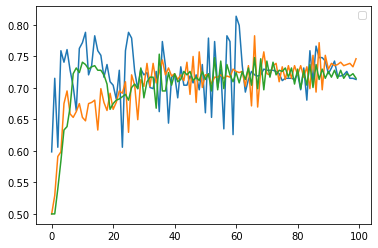

In [ ]:
l=[]
for v in salvataggi:
  if salvataggi[v]["best_val_auc"]>0.9:
    l.append(salvataggi[v]["history_accuracy"]["val"])
#LOSS
#plt.title("modello 2 gat e 2linear "+str((len(history_loss["val"])))+" epoche")
for i in range(len(l)):
  plt.plot(l[i])
plt.legend()
#plt.savefig(imagePath+'LossTrainClassificatoreCompleto.png')
plt.show()